## Link Prediction in Graphs
Predicting Missing Edges in network using graph-based similarity features and logistic regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

## 1. Graph Generation

In [2]:
df_attributes = pd.read_csv('attributes.csv')
df_predictions = pd.read_csv('predictions.csv')
df_solution_input = pd.read_csv('solutionInput.csv')
train_edgelist = pd.read_csv('edges_train.edgelist', names=['i', 'j'])
display(df_attributes, df_predictions, df_solution_input, train_edgelist)

,ID,attribute
0,0,l
1,1,x
2,2,x
3,3,x
4,4,x
...,...,...
1495,1495,l
1496,1496,l
1497,1497,l
1498,1498,f


,ID,prediction
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
1461,1461,0
1462,1462,0
1463,1463,0
1464,1464,0


,ID,int1,int2
0,0,56,396
1,1,760,853
2,2,340,1137
3,3,597,771
4,4,1355,1410
...,...,...,...
1461,1461,342,828
1462,1462,1066,1103
1463,1463,375,1376
1464,1464,1017,1350


,i,j
0,0,5
1,0,6
2,0,7
3,0,8
4,0,9
...,...,...
6595,1463,1493
6596,1469,1499
6597,1481,1498
6598,1487,1490


In [3]:
G = nx.read_edgelist("edges_train.edgelist", data=False, nodetype = int, delimiter=',') # import
pos = nx.spring_layout(G)

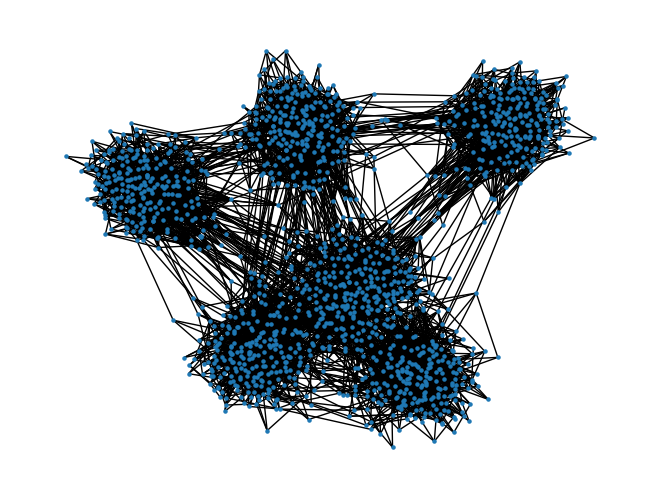

In [4]:
nx.draw(G, pos=pos, node_size=5)

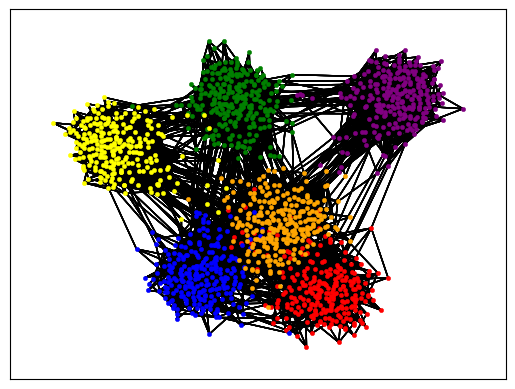

In [5]:
from networkx.algorithms.community import greedy_modularity_communities
#the function will return a partition of nodes
c = list(greedy_modularity_communities(G, resolution=1.4))

colors=  ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
for i,l in enumerate(c):
    nx.draw_networkx(G, nodelist=sorted(l), node_color=colors[i], pos=pos, node_size=10, with_labels=False, linewidths=0.3)

## 2. Feature Creation for Feature Importance Comparision
To explore contribution of features for making predictions 7 important features being: Common Neighbours, Jaccard, Preferential Attatchment, Adamic Adar, Attribute Similarity, Resource Allocation and Katz Index were created. 

In [6]:
def common_neighbors(G, i, j):
    # number of common neighbors
    return len(list(nx.common_neighbors(G, i, j)))

def jaccard_coefficient(G, i, j):
    # 
    preds = nx.jaccard_coefficient(G, [(i, j)])
    for (u, v, p) in preds:
        return p

def preferential_attachment(G, i, j):
    preds = nx.preferential_attachment(G, [(i, j)])
    for (u, v, p) in preds:
        return p

def adamic_adar(G, i, j):
    preds = nx.adamic_adar_index(G, [(i, j)])
    for (u, v, p) in preds:
        return p

def attribute_similarity(df_attributes, i, j):
    # 0 if attributes of nodes are different, 1 if they are the same
    return int(df_attributes.loc[i, 'attribute'] == df_attributes.loc[j, 'attribute'])

def resource_allocation(G, i, j):
    preds = nx.resource_allocation_index(G, [(i, j)])
    for (u, v, p) in preds:
        return p

def katz_index_score(G, i, j, alpha=0.05, max_path_length=4):
    katz_score = 0

    G_copy = G.copy()
    
    # Remove the edge between nodes i and j (if it exists)
    if G_copy.has_edge(i, j):
        G_copy.remove_edge(i, j)

    # Add paths of varying lengths (1 to max_path_length)
    for path_length in range(1, max_path_length + 1):
        paths_of_length = sum(1 for _ in nx.all_simple_paths(G_copy, source=i, target=j, cutoff=path_length) if len(_) == path_length + 1)
        katz_score += (alpha ** path_length) * paths_of_length
    
    return katz_score

In [9]:
def generate_features(G, df_attributes, i, j):
    return [common_neighbors(G, i, j),
            jaccard_coefficient(G, i, j),
            preferential_attachment(G, i, j),
            adamic_adar(G, i, j),
            attribute_similarity(df_attributes, i, j),
            resource_allocation(G, i, j),
            katz_index_score(G, i,j)]

#Compute number of nodes in the network
N = len(list(G.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(G.edges))
print("The network has ", E, " edges")

The network has  1500  nodes
The network has  6600  edges


## 3. Node and Edges Calculations
Positive and Negaive examples creation.

In [15]:
import numpy as np
import networkx as nx
from tqdm import tqdm

# Function to generate random non-edges in bulk
def generate_negative_edges(G, num_samples, num_nodes):
    negative_edges = set()

    while len(negative_edges) < num_samples:
        # Generate random pairs (i, j) efficiently
        i = np.random.randint(0, num_nodes, num_samples)
        j = np.random.randint(0, num_nodes, num_samples)

        # Filter out invalid edges (self-loops or already existing edges)
        new_edges = [(i[k], j[k]) for k in range(num_samples) if i[k] != j[k] and not G.has_edge(i[k], j[k])]
        negative_edges.update(new_edges)
    
    return list(negative_edges)[:num_samples]  # Return exactly the number needed

# Precompute the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Number of negative examples: You can balance this as needed
num_negative_samples = num_edges  # Same as number of positive samples

# Generate negative examples in bulk
negative_edges = generate_negative_edges(G, num_negative_samples, num_nodes)


In [17]:
from joblib import Parallel, delayed

# Parallel function to generate features for a batch of edges
def generate_features_batch(G, df_attributes, edges):
    return [generate_features(G, df_attributes, i, j) for (i, j) in edges]

# Example: Positive examples
positive_edges = list(G.edges)

# Use parallel processing to generate features for edges in batches
X_pos = Parallel(n_jobs=-1, backend='loky')(delayed(generate_features_batch)(G, df_attributes, positive_edges[i:i+1000]) 
                                             for i in range(0, len(positive_edges), 1000))

# Flatten the result from parallel processing
X_pos = [item for sublist in X_pos for item in sublist]
Y_pos = [1] * len(X_pos)

# Example: Negative examples
X_neg = Parallel(n_jobs=-1, backend='loky')(delayed(generate_features_batch)(G, df_attributes, negative_edges[i:i+1000]) 
                                             for i in range(0, len(negative_edges), 1000))

# Flatten the result from parallel processing
X_neg = [item for sublist in X_neg for item in sublist]
Y_neg = [0] * len(X_neg)


In [18]:
# Combine positive and negative examples
X = np.array(X_pos + X_neg)
Y = np.array(Y_pos + Y_neg)

In [19]:
X.shape, Y.shape

((13200, 7), (13200,))

## 4. Scaling of Data
Due to extreme ranges of features data scaling was applied to training data.

## Min Max Scale X

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_df = pd.DataFrame(X)
X_scaled = scaler.fit_transform(X)
X = X_scaled

In [15]:
X.shape, Y.shape, Y.sum()

((13200, 7), (13200,), 6600)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_old = X.copy()
X = scaler.fit_transform(X_old)

## 4. Exploring Different Models for Link Prediction
As the problem is a binary classification problem, different classification models were fitted and compared to dummy classifier to test models against random predictions. Both simple, easily interpretable models such as Logistic Regression Random and potentially more complex models such as Gradient Boosting were explored. 

## Random Classifier

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline

# split into train and validation set 
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=746)

def print_model_validation(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"Accuracy: {round(accuracy_score(y_val, y_pred), 3)}")
    print(f"Precision: {round(precision_score(y_val, y_pred), 3)}")
    print(f"Recall: {round(recall_score(y_val, y_pred), 3)}")
    print(f"F1 Score: {round(f1_score(y_val, y_pred), 3)}")
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix: \n", cm)
    
    # Get predicted probabilities for the positive class (1)
    y_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for class 1 (link exists)
    
    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


## Dummy Classifier for Model Comparison

Accuracy: 0.497
Precision: 0.491
Recall: 0.505
F1 Score: 0.498
Confusion Matrix: 
 [[ 979 1024]
 [ 969  988]]


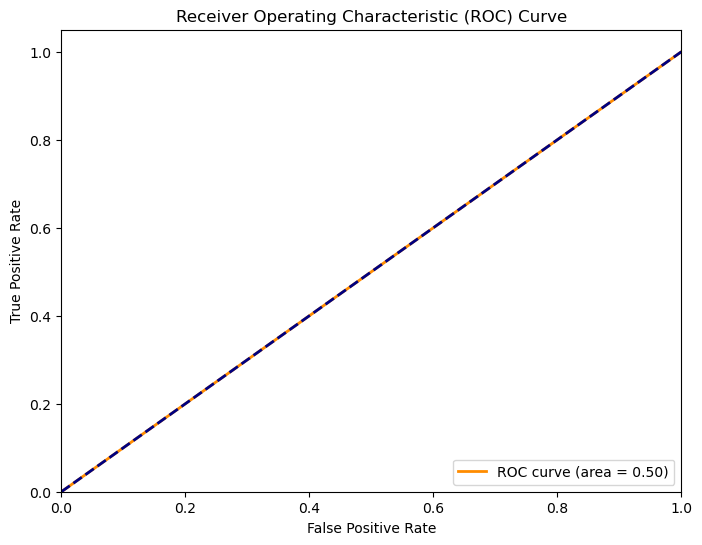

In [58]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="uniform")
dummy.fit(X_train, y_train)

print_model_validation(dummy, X_val, y_val)

[[0.35950666 0.19738601 0.36215001 0.25093783 1.05495326 0.17814472
  0.69630047]]
[0.00608225 0.00125541 0.00530303 0.00341991 0.21727273 0.00209957
 0.02415584] 

Accuracy: 0.817
Precision: 0.824
Recall: 0.801
F1 Score: 0.812
Confusion Matrix: 
 [[1667  336]
 [ 389 1568]]


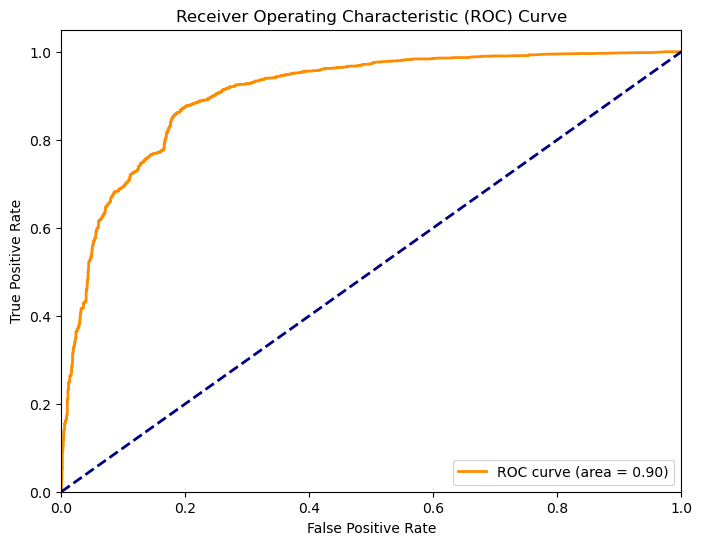

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

model = LogisticRegression(C=0.6, penalty='l2', random_state=746, max_iter=1000)
model.fit(X_train, y_train)

# Those values, however, will show that the second parameter
# is more influential
print(np.std(X, 0)*model.coef_)

# compute importances
model_fi = permutation_importance(model, X_train, y_train)
print(model_fi['importances_mean'], '\n')   

print_model_validation(model, X_val, y_val)

# Logistic Regression

In [45]:
# parameters to fluctuate through cross-validation
param_grid = {
    'logisticregression__C': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
}


model = make_pipeline(LogisticRegression(random_state=746, max_iter=1000))
grid = GridSearchCV(model, param_grid, verbose=1, error_score='raise')
grid.fit(X, Y);

# Let us know check the results with the best estimator after Grid Search
print("Best hyperparameters found:")
print(grid.best_params_)
print("")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters found:
{'logisticregression__C': 2.0}



Fold 1:
  Accuracy: 0.82
  Precision: 0.824
  Recall: 0.814
  F1 Score: 0.819

Fold 2:
  Accuracy: 0.839
  Precision: 0.829
  Recall: 0.854
  F1 Score: 0.841

Fold 3:
  Accuracy: 0.819
  Precision: 0.833
  Recall: 0.799
  F1 Score: 0.816

Fold 4:
  Accuracy: 0.839
  Precision: 0.832
  Recall: 0.848
  F1 Score: 0.84

Fold 5:
  Accuracy: 0.82
  Precision: 0.816
  Recall: 0.828
  F1 Score: 0.822



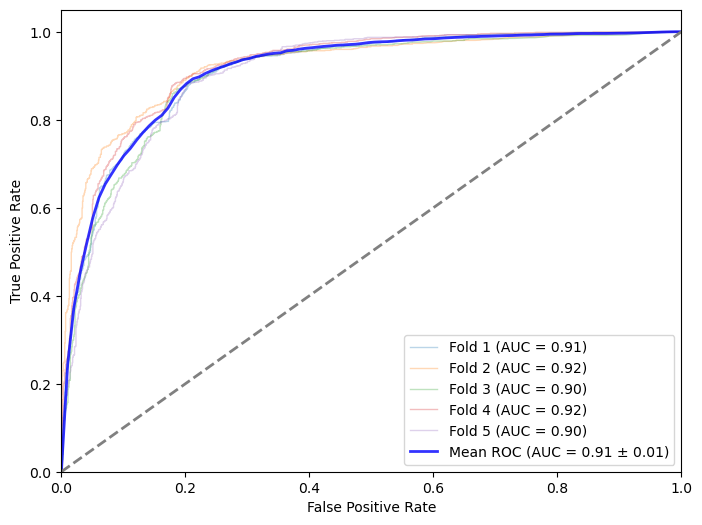


Average Metrics Across All Folds:
  Mean Accuracy: 0.828
  Mean Precision: 0.827
  Mean Recall: 0.829
  Mean F1 Score: 0.828


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract the best model from the grid search
best_model = grid.best_estimator_

# Arrays to store the true positive rate (TPR) and area under curve (AUC) values for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # For interpolation of ROC curves

# Arrays to store accuracy, precision, recall, and F1 for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Set up the plot
plt.figure(figsize=(8, 6))

# Perform cross-validation and plot ROC curve for each fold
for i, (train_index, test_index) in enumerate(cv.split(X, Y)):
    # Train the model on the training set of the current fold
    best_model.fit(X[train_index], Y[train_index])

    # Get predicted probabilities for the positive class
    y_proba = best_model.predict_proba(X[test_index])[:, 1]

    # Predict class labels based on probabilities
    y_pred = best_model.predict(X[test_index])

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(Y[test_index], y_proba)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Interpolate to compute the mean ROC later
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # TPR should start at 0.0

    # Store the AUC for the fold
    aucs.append(roc_auc)

    # Plot the ROC curve for the fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    # Compute additional metrics for this fold
    accuracy = accuracy_score(Y[test_index], y_pred)
    precision = precision_score(Y[test_index], y_pred)
    recall = recall_score(Y[test_index], y_pred)
    f1 = f1_score(Y[test_index], y_pred)

    # Store metrics for each fold
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    # Print the metrics for each fold
    print(f"Fold {i+1}:")
    print(f"  Accuracy: {round(accuracy, 3)}")
    print(f"  Precision: {round(precision, 3)}")
    print(f"  Recall: {round(recall, 3)}")
    print(f"  F1 Score: {round(f1, 3)}\n")

# Plotting the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # TPR should end at 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)

# Plot the random classifier's ROC (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve - Random Forest (Cross-Validation)')
plt.legend(loc='lower right')
#plt.savefig('ROCCURVE.eps', format='eps', bbox_inches='tight')
plt.show()

# Compute mean and standard deviation of the metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print("\nAverage Metrics Across All Folds:")
print(f"  Mean Accuracy: {round(mean_accuracy, 3)}")
print(f"  Mean Precision: {round(mean_precision, 3)}")
print(f"  Mean Recall: {round(mean_recall, 3)}")
print(f"  Mean F1 Score: {round(mean_f1, 3)}")


Accuracy: 0.85
Precision: 0.838
Recall: 0.864
F1 Score: 0.851
Confusion Matrix: 
 [[1675  328]
 [ 266 1691]]


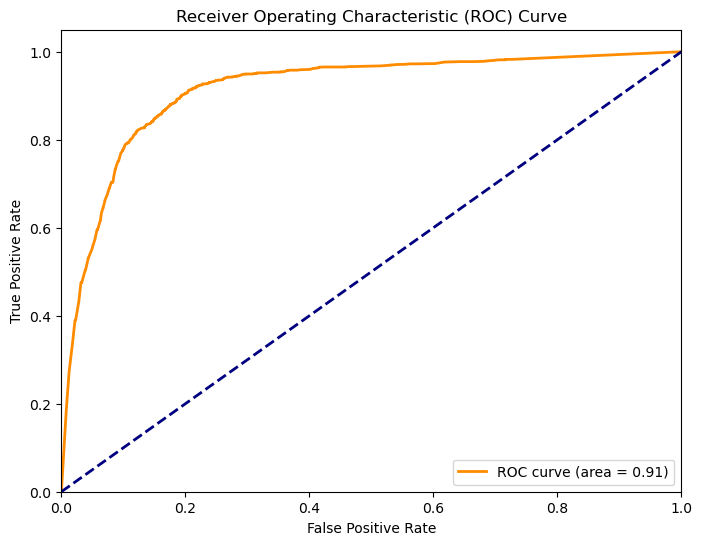

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=746)
rf_model.fit(X_train, y_train)

print_model_validation(rf_model, X_val, y_val)

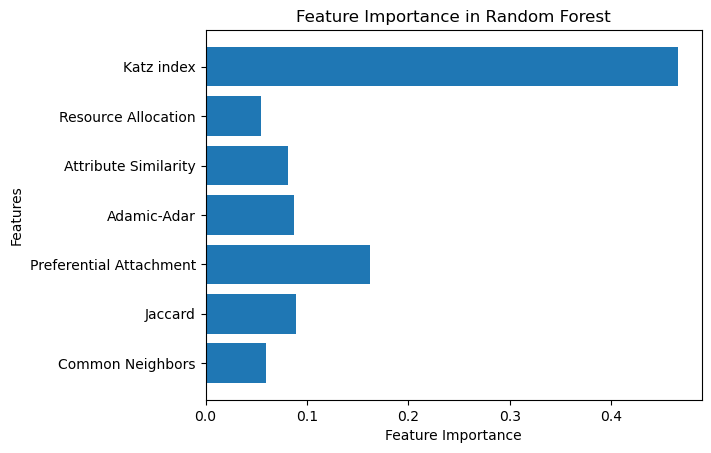

In [36]:
feature_importances = rf_model.feature_importances_
feature_names = ['Common Neighbors', 'Jaccard', 'Preferential Attachment', 'Adamic-Adar', 'Attribute Similarity', 'Resource Allocation', 'Katz index']#, 'Shortest Path']

plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()

# Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 150, 200],       # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1],    # Shrinkage rate
    'max_depth': [5, 10],               # Maximum depth of each tree
    'min_samples_split': [2, 5],       # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],         # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt']         # Number of features to consider when splitting
}

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=746)

# Set up GridSearchCV with cross-validation
grid = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model on the training data
grid.fit(X, Y)

# Output the best hyperparameters found
print("Best hyperparameters found:")
print(grid.best_params_)
print("")

# Access the best estimator from the Grid Search
best_model = grid.best_estimator_

# Use best_model for predictions, evaluation, etc.


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters found:
{'learning_rate': 0.01, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}



Fold 1:
  Accuracy: 0.859
  Precision: 0.851
  Recall: 0.872
  F1 Score: 0.861

Fold 2:
  Accuracy: 0.873
  Precision: 0.852
  Recall: 0.904
  F1 Score: 0.877

Fold 3:
  Accuracy: 0.877
  Precision: 0.855
  Recall: 0.908
  F1 Score: 0.881

Fold 4:
  Accuracy: 0.882
  Precision: 0.844
  Recall: 0.937
  F1 Score: 0.888

Fold 5:
  Accuracy: 0.876
  Precision: 0.852
  Recall: 0.909
  F1 Score: 0.88



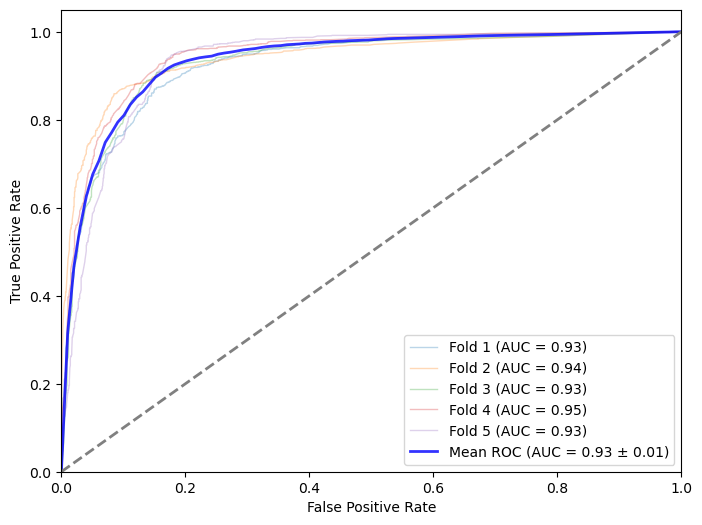


Average Metrics Across All Folds:
  Mean Accuracy: 0.873
  Mean Precision: 0.851
  Mean Recall: 0.906
  Mean F1 Score: 0.877


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract the best model from the grid search
best_model = grid.best_estimator_

# Arrays to store the true positive rate (TPR) and area under curve (AUC) values for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # For interpolation of ROC curves

# Arrays to store accuracy, precision, recall, and F1 for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Set up the plot
plt.figure(figsize=(8, 6))

# Perform cross-validation and plot ROC curve for each fold
for i, (train_index, test_index) in enumerate(cv.split(X, Y)):
    # Train the model on the training set of the current fold
    best_model.fit(X[train_index], Y[train_index])

    # Get predicted probabilities for the positive class
    y_proba = best_model.predict_proba(X[test_index])[:, 1]

    # Predict class labels based on probabilities
    y_pred = best_model.predict(X[test_index])

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(Y[test_index], y_proba)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Interpolate to compute the mean ROC later
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # TPR should start at 0.0

    # Store the AUC for the fold
    aucs.append(roc_auc)

    # Plot the ROC curve for the fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    # Compute additional metrics for this fold
    accuracy = accuracy_score(Y[test_index], y_pred)
    precision = precision_score(Y[test_index], y_pred)
    recall = recall_score(Y[test_index], y_pred)
    f1 = f1_score(Y[test_index], y_pred)

    # Store metrics for each fold
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    # Print the metrics for each fold
    print(f"Fold {i+1}:")
    print(f"  Accuracy: {round(accuracy, 3)}")
    print(f"  Precision: {round(precision, 3)}")
    print(f"  Recall: {round(recall, 3)}")
    print(f"  F1 Score: {round(f1, 3)}\n")

# Plotting the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # TPR should end at 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)

# Plot the random classifier's ROC (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve - Random Forest (Cross-Validation)')
plt.legend(loc='lower right')
#plt.savefig('ROCCURVE.eps', format='eps', bbox_inches='tight')
plt.show()

# Compute mean and standard deviation of the metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print("\nAverage Metrics Across All Folds:")
print(f"  Mean Accuracy: {round(mean_accuracy, 3)}")
print(f"  Mean Precision: {round(mean_precision, 3)}")
print(f"  Mean Recall: {round(mean_recall, 3)}")
print(f"  Mean F1 Score: {round(mean_f1, 3)}")


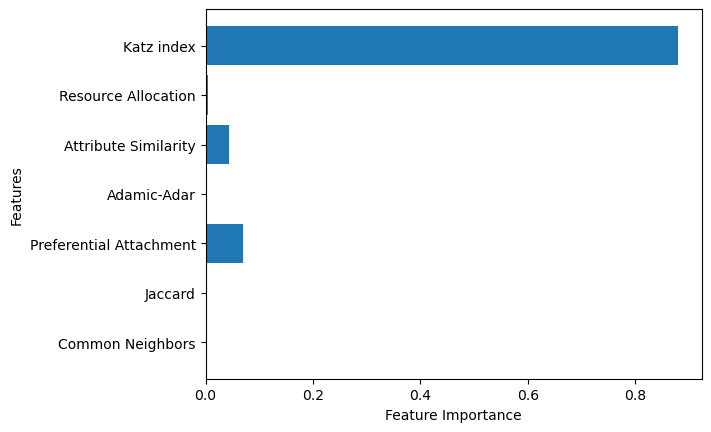

In [56]:
feature_importances = grid.best_estimator_.feature_importances_
feature_names = ['Common Neighbors', 'Jaccard', 'Preferential Attachment', 'Adamic-Adar', 'Attribute Similarity', 'Resource Allocation', 'Katz index']#, 'Shortest Path']

plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
#plt.title('Feature Importance in Random Forest')
#plt.savefig('feature_importances.eps', format='eps', bbox_inches='tight')
plt.show()

# Random Forest
To tune hyperparameters of the model Grid Search 5-Fold Cross Validation was applied to obtain best hyperparameters.

In [39]:
# parameters to fluctuate through cross-validation
param_grid = {
    'randomforestclassifier__n_estimators': [100, 125, 150, 175, 200],
    'randomforestclassifier__max_depth': [2, 3, 5, 7, 9],
    'randomforestclassifier__min_samples_split': [2, 3],
}

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees in the forest
    'max_depth': [5, 10, 20, None],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt'],  # Number of features to consider for best split
}


model = RandomForestClassifier(random_state=746)
grid = GridSearchCV(model, param_grid, verbose=1)
grid.fit(X, Y);

# Let us know check the results with the best estimator after Grid Search
print("Best hyperparameters found:")
print(grid.best_params_)
print("")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}



Fold 1:
  Accuracy: 0.859
  Precision: 0.848
  Recall: 0.873
  F1 Score: 0.861

Fold 2:
  Accuracy: 0.872
  Precision: 0.852
  Recall: 0.902
  F1 Score: 0.876

Fold 3:
  Accuracy: 0.871
  Precision: 0.849
  Recall: 0.902
  F1 Score: 0.875

Fold 4:
  Accuracy: 0.883
  Precision: 0.846
  Recall: 0.936
  F1 Score: 0.888

Fold 5:
  Accuracy: 0.875
  Precision: 0.854
  Recall: 0.905
  F1 Score: 0.879



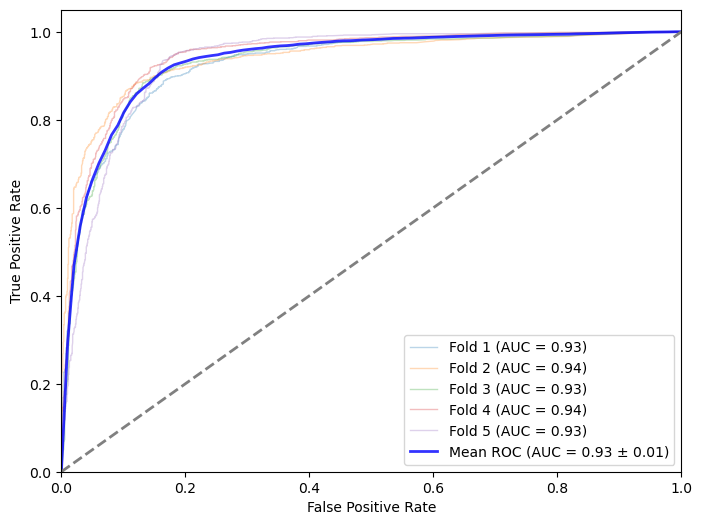


Average Metrics Across All Folds:
  Mean Accuracy: 0.872
  Mean Precision: 0.85
  Mean Recall: 0.903
  Mean F1 Score: 0.876


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract the best model from the grid search
best_model = grid.best_estimator_

# Arrays to store the true positive rate (TPR) and area under curve (AUC) values for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # For interpolation of ROC curves

# Arrays to store accuracy, precision, recall, and F1 for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Set up the plot
plt.figure(figsize=(8, 6))

# Perform cross-validation and plot ROC curve for each fold
for i, (train_index, test_index) in enumerate(cv.split(X, Y)):
    # Train the model on the training set of the current fold
    best_model.fit(X[train_index], Y[train_index])

    # Get predicted probabilities for the positive class
    y_proba = best_model.predict_proba(X[test_index])[:, 1]

    # Predict class labels based on probabilities
    y_pred = best_model.predict(X[test_index])

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(Y[test_index], y_proba)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Interpolate to compute the mean ROC later
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # TPR should start at 0.0

    # Store the AUC for the fold
    aucs.append(roc_auc)

    # Plot the ROC curve for the fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    # Compute additional metrics for this fold
    accuracy = accuracy_score(Y[test_index], y_pred)
    precision = precision_score(Y[test_index], y_pred)
    recall = recall_score(Y[test_index], y_pred)
    f1 = f1_score(Y[test_index], y_pred)

    # Store metrics for each fold
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    # Print the metrics for each fold
    print(f"Fold {i+1}:")
    print(f"  Accuracy: {round(accuracy, 3)}")
    print(f"  Precision: {round(precision, 3)}")
    print(f"  Recall: {round(recall, 3)}")
    print(f"  F1 Score: {round(f1, 3)}\n")

# Plotting the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # TPR should end at 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)

# Plot the random classifier's ROC (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve - Random Forest (Cross-Validation)')
plt.legend(loc='lower right')
#plt.savefig('ROCCURVE.eps', format='eps', bbox_inches='tight')
plt.show()

# Compute mean and standard deviation of the metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print("\nAverage Metrics Across All Folds:")
print(f"  Mean Accuracy: {round(mean_accuracy, 3)}")
print(f"  Mean Precision: {round(mean_precision, 3)}")
print(f"  Mean Recall: {round(mean_recall, 3)}")
print(f"  Mean F1 Score: {round(mean_f1, 3)}")


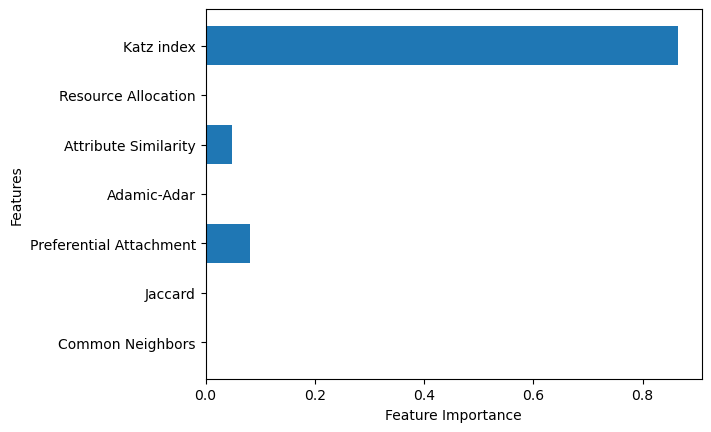

In [41]:
feature_importances = grid.best_estimator_.feature_importances_
feature_names = ['Common Neighbors', 'Jaccard', 'Preferential Attachment', 'Adamic-Adar', 'Attribute Similarity', 'Resource Allocation', 'Katz index']#, 'Shortest Path']

plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
#plt.title('Feature Importance in Random Forest')
#plt.savefig('feature_importances.eps', format='eps', bbox_inches='tight')
plt.show()

## 4. Model Testing and Prediction

## Fill test data

In [60]:
# Return Solution
inp_test = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")
inp_test = np.array(inp_test)
inp = []

for i in inp_test:
    inp.append(generate_features(G, df_attributes, i[0], i[1]))

scaler = MinMaxScaler()
test_X_scaled = scaler.fit_transform(inp) 

y_pred_test = grid.best_estimator_.predict(test_X_scaled)
print(len(y_pred_test), y_pred_test.sum())
results = np.column_stack((inp_test, y_pred_test))
results

1466 756


array([[  56,  396,    0],
       [ 760,  853,    1],
       [ 340, 1137,    0],
       ...,
       [ 375, 1376,    0],
       [1017, 1350,    0],
       [ 540,  688,    1]], dtype=int64)

In [64]:
from datetime import datetime

current_datetime = datetime.now()
pd.DataFrame(y_pred_test).to_csv(f'solutionResults_{current_datetime.year}{current_datetime.month}{current_datetime.day}{current_datetime.hour}{current_datetime.minute}.csv', index=True, header=['prediction'], index_label="ID")

## 5. Summary and Findings

The Random Forest Classifier and Gradient Boosting performed nearly identical and were the best performing models, however the Random Forest Classifier is selected as it is a simpler, computationally fast and easily interpretable model yet performs well. Using 5-fold Cross Validation, 5 sets of validation metrics were obtained and  the mean of them was obtained to get representative values. The cross validation uses Accuracy to test the models of the hyperparameter tuning and this is also the measurement which will is used to test the test set. Other metrics such as Precision, Recall, F1 score and the Receiver Operating Curve (ROC) were also considered to check the Area Under the Curve (AUC), which shows how well the model performs on the positive predictions. The Random Forest Classifier performed well, with a mean Accuracy of 0.872, mean Precision of 0.850, mean Recall of 0.903, mean F1 score of 0.876 and mean AUC of 0.93. They are all high scores The model performs much better than the dummy classifier, of which all metrics are around 0.5 as the data is binary and the split is 50/50. As Random Forest Classifier was used, the feature importance can be analazed to asses what features are most important in predictions. Out of all used important features thus: Katz Index, Resource Allocation, Attribute Similarity, Adamic-Adar, Preferential Attatchment, Jaccard and Common Neighbours the model did not use four of the seven features, and it heavily relied on the Katz Index.

## 6. Limitations

Despite the Random Forest Classifier performed well, there are some limitations to the approach. One of the primary challenges was the calculation of the Katz Index. Although it’s a powerful predictor for link formation, computing all possible paths between nodes is computationally restricted. To manage this, the path length was lkimited to 4 and fixed the decay factor at 0.1, consequently some predictive depth was sacrificed to maintain efficiency. This compromise likely constrained the model’s ability to capture deeper network dynamics, which may limit its performance in more complex networks.
Before implementing the Random Forest Classifier to the data, Min Max scaling was also applied to training data considering the extreme differences in the ranges of features. However, we this approach contributed to model performance only a little which seems valid as Random Forests are based on decision trees, which do not rely on the distance between data points. Instead, the model works by splitting data based on feature values. As a result, some features contain large range might dominate the feature importance score. Additionally, plotting the feature importance showed a heavy reliance on the Katz Index, with other features largely or completely ignored. This over-reliance indicates that chosen model might be overly tuned to one specific feature, raising concerns about how well it will generalize to other datasets or network types where Katz may not be as relevant. Finally, by incorporating attribute similarity as a feature, potential ethical concerns may be intorduced. These attributes could represent sensitive information, consequently in future work it is recommended to explore bias mitigation and ethical conserns of the solution.